In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as dr
import numpy as np
from datetime import datetime
from datetime import timedelta

In [64]:
# The stock ticker and the number of years 
# of historical data
ticker = "BTC-USD"
num_years = 2

# Collecting stock historical data from yahoo
today = datetime.now()
two_years_ago = today - timedelta(days=num_years * 365)
data = dr.data.get_data_yahoo(ticker, start=two_years_ago, end=today)

# Let's take a look at what we have
data.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-12,10441.489258,10226.596680,10415.362305,10360.546875,1.410986e+10,10360.546875
2019-09-13,10422.133789,10291.694336,10345.403320,10358.048828,1.346871e+10,10358.048828
2019-09-14,10387.035156,10313.092773,10356.465820,10347.712891,1.204343e+10,10347.712891
2019-09-15,10386.867188,10189.744141,10347.222656,10276.793945,1.516017e+10,10276.793945
2019-09-16,10296.771484,10199.739258,10281.513672,10241.272461,1.530460e+10,10241.272461


In [65]:
# Adding a new column "Prediction" corresponding to the next day close price.
# Note that we are discarding the last row since we don't know tomorrows price.
data["Prediction"] = data["Close"].shift(-1)
data = data[:-1]

# Removing nans and infs values
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]

# Let's take another look on the results
data.tail()

,High,Low,Open,Close,Volume,Adj Close,Prediction
Date,,,,,,,
2021-09-06,52853.765625,43285.207031,52660.480469,46811.128906,6.521006e+10,46811.128906,46091.390625
2021-09-07,47334.054688,44561.394531,46827.761719,46091.390625,4.900776e+10,46091.390625,46391.421875
2021-09-08,47261.949219,45669.738281,45774.742188,46391.421875,3.867266e+10,46391.421875,44883.910156
2021-09-09,47031.742188,44344.484375,46396.664062,44883.910156,3.915467e+10,44883.910156,45201.457031
2021-09-10,45969.292969,44818.265625,44869.839844,45201.457031,3.449984e+10,45201.457031,45991.460938


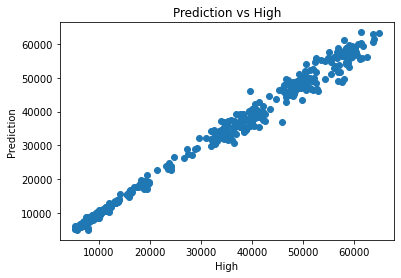

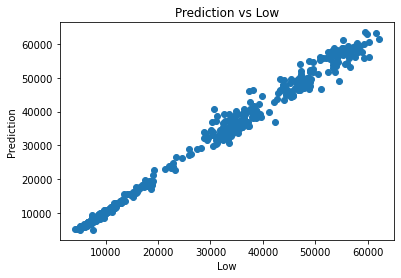

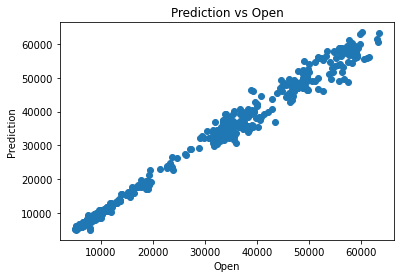

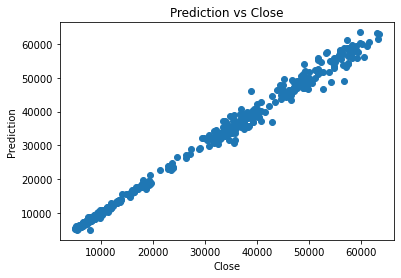

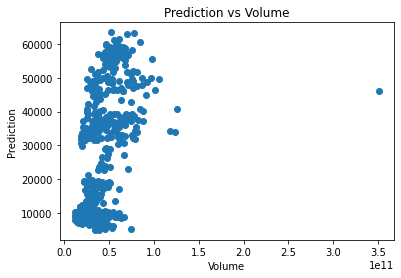

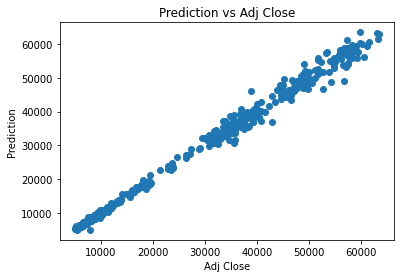

In [66]:
# Let's try to visualize linear correlations (is volume a good feature?)
for k in data.keys():
    if k not in ["Prediction"]:
        plt.title(f"Prediction vs {k}")
        plt.xlabel(f"{k}")
        plt.ylabel("Prediction")
        plt.plot( data[k], data["Prediction"], "o")
        plt.show()


In [67]:
# Defining independent and dependent variables
# Note that we're ignoring the volume because it doesn't seem to 
# have a good linear relationship with the prediction price.
x = data.loc[:,~data.columns.isin(["Volume","Prediction"])].values 
y = data["Prediction"].values.reshape(-1,1)

In [68]:
# Normalizing features
feature_scaler = MinMaxScaler(feature_range=(0,1))
x_normalized = feature_scaler.fit_transform(x)

# Train test split..
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size = 0.3, random_state = 0)

In [69]:
# Creating a linear regression model and fitting on training data
regressor = LinearRegression()
regressor.fit(x_train, y_train)

# Predicting values for the test set and evaluating the model performance
y_test_pred = regressor.predict(x_test)

# The mean squared error
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test, y_test_pred) )

# The coefficient of determination
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_test_pred))

Mean absolute error: 675.51
Coefficient of determination: 1.00


In [70]:
# Checking tomorrows prediction by evaluating last data row
last_row = data.iloc[-1,:]
last_day_date = last_row.name
tomorrow_date = last_day_date + timedelta(days=1)
tomorrow_date_str = tomorrow_date.isoformat().split("T")[0]


x_predict = last_row.loc[ ~last_row.keys().isin(["Volume","Prediction"]) ].values.reshape(-1,5)
x_predict_scaled = feature_scaler.transform(x_predict)
tomorrow_price = regressor.predict( x_predict_scaled )

print( f"The expected price for {ticker} at {tomorrow_date_str} is $ %.2f" % tomorrow_price[0,0] )



The expected price for BTC-USD at 2021-09-11 is $ 45121.82
